## Using GCN on the CommonsenseQA dataset

In [106]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torch.nn.functional as F

from torch.autograd import Variable

import Graph_Conv_Network
import conceptnet2
import importlib
import json
importlib.reload(conceptnet2)
importlib.reload(Graph_Conv_Network)

<module 'Graph_Conv_Network' from '/home/sean/Documents/UCL/Statistical NLP/Commonsense/commonsenseqa-master (2)/Graph_Conv_Network.py'>

In [107]:
CN = conceptnet2.ConceptNet()

In [108]:
CN.load_file()
CN.build_vocab()
CN.load_triplets()
CN.get_source_concept()
CN.construct_subgraph()

In [19]:
def batch_handler_for_GCN(batch_size, CN):
    #returns a list of inputs/outputs in batches of batch_size
    #CN is a conceptnet instance
    n_examples = len(CN.choices)
    
    '''
    feed_list should be populated with dictionaries that have two keys, 'input' and 'adj',
    the value of 'input' is a matrix of dimension (batch_size x n_nodes x feature_size)
    the value of 'adj' is a matrix of dimension (batch_size x n_nodes x n_nodes)
    '''
    feed_list = []
    
    '''
    label_list should be populated with matrices of dimension (batch_size x 1)
    '''
    label_list = [] #should be populated with labels 1,2,3
    
    #convert A,B,C into 0,1,2
    labels = [torch.tensor(('B'==label) + ('C' == label) *2) for label in CN.labels]
    
    n_batches = int(n_examples/batch_size)
    
    for i in range(n_batches):
        start_index = batch_size*i
        end_index = batch_size*(i+1)
        
        temp_labels = torch.tensor(labels[start_index:end_index])
        temp_adj = CN.adjacency_mat[start_index][None,:]
        temp_feat = CN.Gfeature_mat[start_index][None,:]
        
        for j in range(start_index + 1, end_index):
            temp_adj = torch.cat((temp_adj, CN.adjacency_mat[j][None,:]), dim = 0)
            temp_feat = torch.cat((temp_feat, CN.Gfeature_mat[j][None,:]), dim = 0)
            
        feed_list.append({'input':Variable(temp_feat), 'adj':Variable(temp_adj)})
        label_list.append(temp_labels)
    return feed_list, label_list
class Flatten(nn.Module):
    def forward(self, dictionary): 
        #dictionary contains input and adj. we want input
        input = dictionary['input']
        return input.view(input.size()[0],-1)

In [93]:
model = nn.Sequential(Graph_Conv_Network.GCN(768, 40), 
                      Graph_Conv_Network.GCN(40, 10),
                      Flatten(), 
                      nn.Linear(40, 3))

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.7, 0.99))

In [94]:
def train(epochs, batch_size, CN):
    feed_list, label_list = batch_handler_for_GCN(batch_size, CN)
    feed_list = feed_list[0:760]
    label_list = label_list[0:760]
    Training_List = []
    Testing_List = []
    for i in range(epochs):
        
        Loss = 0
        for in_dict, labels in zip(feed_list, label_list):
            # zero gradient
            model.zero_grad()
            
            pred = model(in_dict)
            loss = criterion(pred, labels)
            
            loss.backward()
            
            optimizer.step()
            
            Loss += loss
        
        
        print('Epoch', i, ':', Loss/760)
        Training_List.append(Loss.detach().numpy()/760)
        
        Loss_Test, acc = test(10, CN)
        Testing_List.append(Loss_Test)
        
        
    return(Training_List,Testing_List)

def test(batch_size, CN):
    feed_list, label_list = batch_handler_for_GCN(batch_size, CN)
    feed_list =  feed_list[761:855]
    label_list = label_list[761:855]

    correct = 0
    total = 0
    Loss = 0
    for in_dict, labels in zip(feed_list, label_list):
        # zero gradient

        pred = model(in_dict)
        
        loss = criterion(pred, labels)
        
        Loss += loss
        correct += ((labels == pred.argmax(dim = 1)).sum())
        total += 10

    return(Loss.detach().numpy()/(855-761), correct.float()/total)
Loss, acc = test(10, CN)


Training_Loss, Testing_Loss = train(25, 10, CN)

1.112702065325798
Epoch 0 : tensor(1.1083, grad_fn=<DivBackward0>)
Epoch 1 : tensor(1.1062, grad_fn=<DivBackward0>)
Epoch 2 : tensor(1.0990, grad_fn=<DivBackward0>)
Epoch 3 : tensor(1.0840, grad_fn=<DivBackward0>)
Epoch 4 : tensor(1.0660, grad_fn=<DivBackward0>)
Epoch 5 : tensor(1.0519, grad_fn=<DivBackward0>)
Epoch 6 : tensor(1.0336, grad_fn=<DivBackward0>)
Epoch 7 : tensor(1.0233, grad_fn=<DivBackward0>)
Epoch 8 : tensor(1.0068, grad_fn=<DivBackward0>)
Epoch 9 : tensor(0.9949, grad_fn=<DivBackward0>)
Epoch 10 : tensor(0.9833, grad_fn=<DivBackward0>)
Epoch 11 : tensor(0.9703, grad_fn=<DivBackward0>)
Epoch 12 : tensor(0.9579, grad_fn=<DivBackward0>)
Epoch 13 : tensor(0.9504, grad_fn=<DivBackward0>)
Epoch 14 : tensor(0.9436, grad_fn=<DivBackward0>)
Epoch 15 : tensor(0.9390, grad_fn=<DivBackward0>)
Epoch 16 : tensor(0.9330, grad_fn=<DivBackward0>)
Epoch 17 : tensor(0.9266, grad_fn=<DivBackward0>)
Epoch 18 : tensor(0.9196, grad_fn=<DivBackward0>)
Epoch 19 : tensor(0.9152, grad_fn=<DivBack

In [95]:
Train_loss = np.array(Training_Loss)
Test_loss = np.array(Testing_Loss)

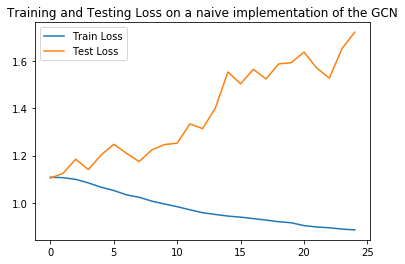

In [96]:
plt.plot(Train_loss, label='Train Loss')
plt.plot(Test_loss, label='Test Loss')
plt.legend()
plt.title('Training and Testing Loss on a naive implementation of the GCN')
plt.show()